## Master of Applied Data Science
### University of Michigan - School of Information
### Capstone Project - Rapid Labeling of Text Corpus Using Information Retrieval Techniques
### Fall 2021
#### Team Members: Chloe Zhang, Michael Penrose, Carlo Tak

### Experiment Flow

Event type > Count vectorizer > 100 features > PyCaret

### Purpose

This notebook investigates how well a classifier can predict the **event type (i.e. 'earthquake', 'fire', 'flood', 'hurricane)** of the Tweets in the [Disaster tweets dataset](https://crisisnlp.qcri.org/humaid_dataset.html#) (Firoj Alam, Umair Qazi, Muhammad Imran and Ferda Ofli, HumAID: Human-Annotated Disaster Incidents Data from Twitter, In ICWSM, 2021).

This classifier is to be used as a baseline of classification performance. Two things are investigated:
- Is it possible to build a reasonable 'good' classifier of these tweets at all
- If it is possible to build a classifier how well does the classifier perform using all of the labels from the training data

If it is possible to build a classifier using all of the labels in the training dataset then it should be possible to implement a method for rapidly labeling the corpus of texts in the dataset. Here we think of rapid labeling as any process that does not require the user to label each text in the corpus, one at a time.

To measure the performance of the classifier we use a metric called the Area Under the Curve (AUC). This metric was used because we believe it is a good metric for the preliminary work in this project. If a specific goal emerges later that requires a different metric, then the appropriate metric can be used at that time. The consequence of false positives (texts classified as having a certain label, but are not that label) and false negatives should be considered. For example, a metric like precision can be used to minimize false positives. The AUC metric provides a value between zero and one, with a higher number indicating better classification performance. 


### Summary

The baseline classifier built using all the labels in the training dataset produced a classifier that had a fairly good AUC score for each of the 4 event type labels (i.e. earthquake, fire, flood, hurricane). All the AUC scores were above 0.98.

A simple vectorization (of texts) approach was implemented because we wanted the baseline classifier to be a basic solution – our feeling was that more complex techniques could be implemented at a later stage. A [count vectorizer]( https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) (with default settings) was used to convert the texts. The number of dimensions (features) was also reduced using feature selection ([SelectKBest]( https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)). This was to improve computational times – fewer dimensions means that there are fewer data to process. Also, this was a simpler method to implement than other techniques like removing stopwords, adjusting parameters like ‘stop_words’, ‘ngram_range’, ‘max_df’, ‘min_df’, and ‘max_features’.  The complexity of the classifier could be adjusted if required, but this simple implementation produced good results.

This notebook reduced the number of features to 100.

The feature importances were extracted from the classifier, to see if they made sense. This sense check was important because we made several assumptions in building this classifier, that had to be validated. For example, when the text was vectorized we used a simple approach that just counted the individual words (tokens) – are more complex classifier might use bi-grams (two words per feature), this would have had the advantage of preserving features like ‘’.

Examining the top features
 



In [1]:
from utilities import dt_utilities as utils
from datetime import datetime

In [2]:
start_time = datetime.now()
start_time.strftime("%Y/%m/%d %H:%M:%S")

'2021/10/02 17:44:22'

In [3]:
consolidated_disaster_tweet_data_df = \
    utils.get_consolidated_disaster_tweet_data(root_directory="data/",
                                               event_type_directory="HumAID_data_event_type",
                                               events_set_directories=["HumAID_data_events_set1_47K",
                                                                       "HumAID_data_events_set2_29K"],
                                               include_meta_data=True)

In [4]:
consolidated_disaster_tweet_data_df

,tweet_id,class_label,event_type,data_type,tweet_text
0,798262465234542592,sympathy_and_support,earthquake,dev,RT @MissEarth: New Zealand need our prayers af...
1,771464543796985856,caution_and_advice,earthquake,dev,"@johnaglass65 @gordonluke Ah, woke up to a nig..."
2,797835622471733248,requests_or_urgent_needs,earthquake,dev,RT @terremotocentro: #eqnz if you need a tool ...
3,798021801540321280,other_relevant_information,earthquake,dev,RT @BarristerNZ: My son (4) has drawn a pictur...
4,798727277794033664,infrastructure_and_utility_damage,earthquake,dev,Due to earthquake damage our Defence Force is ...
...,...,...,...,...,...
76479,783991683188948992,infrastructure_and_utility_damage,hurricane,train,RT @LindsayLogue: 3500+ homes destroyed in Haiti
76480,783794225368276992,not_humanitarian,hurricane,train,"@ClintonFdn stay out of Haiti, you will not ge..."
76481,783399699994648576,other_relevant_information,hurricane,train,Hurricane-hit southern Haiti cut off after bri...
76482,783400762898391041,sympathy_and_support,hurricane,train,Please pray for these beautiful people.


In [5]:
train_df = consolidated_disaster_tweet_data_df[consolidated_disaster_tweet_data_df["data_type"]=="train"].reset_index(drop=True)
train_df

,tweet_id,class_label,event_type,data_type,tweet_text
0,798064896545996801,other_relevant_information,earthquake,train,I feel a little uneasy about the idea of work ...
1,797913886527602688,caution_and_advice,earthquake,train,#eqnz Interislander ferry docking aborted afte...
2,797867944546025472,other_relevant_information,earthquake,train,Much of New Zealand felt the earthquake after ...
3,797958935126773760,sympathy_and_support,earthquake,train,"Noticing a lot of aftershocks on eqnz site, bu..."
4,797813020567056386,infrastructure_and_utility_damage,earthquake,train,"RT @E2NZ: Mike Clements, NZ police, says obvio..."
...,...,...,...,...,...
53526,783991683188948992,infrastructure_and_utility_damage,hurricane,train,RT @LindsayLogue: 3500+ homes destroyed in Haiti
53527,783794225368276992,not_humanitarian,hurricane,train,"@ClintonFdn stay out of Haiti, you will not ge..."
53528,783399699994648576,other_relevant_information,hurricane,train,Hurricane-hit southern Haiti cut off after bri...
53529,783400762898391041,sympathy_and_support,hurricane,train,Please pray for these beautiful people.


In [6]:
test_df = consolidated_disaster_tweet_data_df[consolidated_disaster_tweet_data_df["data_type"]=="test"].reset_index(drop=True)
test_df

,tweet_id,class_label,event_type,data_type,tweet_text
0,798274825441538048,infrastructure_and_utility_damage,earthquake,test,The earthquake in New Zealand was massive. Bil...
1,798452064208568320,infrastructure_and_utility_damage,earthquake,test,These pictures show the alarming extent of the...
2,797804396767682560,sympathy_and_support,earthquake,test,Just woke to news of another earthquake! WTF N...
3,798434862830993408,not_humanitarian,earthquake,test,"When theres an actual earthquake, landslide an..."
4,797790705414377472,caution_and_advice,earthquake,test,"Tsunami warning for entire East Coast of NZ, b..."
...,...,...,...,...,...
15155,783985895493865472,caution_and_advice,hurricane,test,RT @rolandsmartin: 7AM ET on #NewsOneNow: Hurr...
15156,783746504129294336,sympathy_and_support,hurricane,test,RT @ILiveBeyond: Please pray for the people of...
15157,783864123167608832,injured_or_dead_people,hurricane,test,Hurricane Matthew kills 26 in Caribbean on des...
15158,783528309963579392,injured_or_dead_people,hurricane,test,An already struggling Haiti faced massive Hurr...


In [7]:
dev_df = consolidated_disaster_tweet_data_df[consolidated_disaster_tweet_data_df["data_type"]=="dev"].reset_index(drop=True)
dev_df

,tweet_id,class_label,event_type,data_type,tweet_text
0,798262465234542592,sympathy_and_support,earthquake,dev,RT @MissEarth: New Zealand need our prayers af...
1,771464543796985856,caution_and_advice,earthquake,dev,"@johnaglass65 @gordonluke Ah, woke up to a nig..."
2,797835622471733248,requests_or_urgent_needs,earthquake,dev,RT @terremotocentro: #eqnz if you need a tool ...
3,798021801540321280,other_relevant_information,earthquake,dev,RT @BarristerNZ: My son (4) has drawn a pictur...
4,798727277794033664,infrastructure_and_utility_damage,earthquake,dev,Due to earthquake damage our Defence Force is ...
...,...,...,...,...,...
7788,783947842092138497,rescue_volunteering_or_donation_effort,hurricane,dev,U.S. Nonprofit All Hands Volunteers Heads To H...
7789,783838361425440768,other_relevant_information,hurricane,dev,RT @Aaylin_xoxo: It breaks my heart to see how...
7790,783860660388007937,other_relevant_information,hurricane,dev,TBH nobody know what hurricane Mathew gone do ...
7791,784689762032508928,injured_or_dead_people,hurricane,dev,Hurricane Matthew Barrels Up The East Coast Af...


In [8]:
train_df.groupby(["event_type"]).size().reset_index().rename(columns={0: "Count"}).sort_values("Count", ascending=False)

,event_type,Count
3,hurricane,31674
2,flood,7815
1,fire,7792
0,earthquake,6250


In [9]:
train_df.groupby(["class_label"]).size().reset_index().rename(columns={0: "Count"}).sort_values("Count", ascending=False)

,class_label,Count
8,rescue_volunteering_or_donation_effort,14891
6,other_relevant_information,8501
9,sympathy_and_support,6250
2,infrastructure_and_utility_damage,5715
3,injured_or_dead_people,5110
5,not_humanitarian,4407
0,caution_and_advice,3774
1,displaced_people_and_evacuations,2800
7,requests_or_urgent_needs,1833
4,missing_or_found_people,250


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline
import pandas as pd
from scipy.sparse import coo_matrix, hstack
import scipy.sparse
import numpy as np
from collections import Counter

In [11]:
num_features = 100
target_column = "event_type"
# vectorizer = TfidfVectorizer(max_features=num_features)
# count_vectorizer = CountVectorizer(max_features=num_features)

vectorizer = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("reduce", SelectKBest(score_func=f_classif, k=num_features)), # chi2, f_classif
])

In [12]:
vectorizer.fit(train_df["tweet_text"], train_df[target_column])

Pipeline(steps=[('vectorizer', CountVectorizer()), ('reduce', SelectKBest())])

In [13]:
def vectorized_tweet_data(fitted_vectorizer, source_df, text_column, target_column, 
                          vectorizer_name="vectorizer", reducer_name="reduce"):
    vectorized_data = fitted_vectorizer.transform(source_df[text_column])
    
    vectorized_df = pd.DataFrame.sparse.from_spmatrix(vectorized_data)
    
    all_feature_names = fitted_vectorizer.named_steps[vectorizer_name].get_feature_names()
    support = vectorizer.named_steps[reducer_name].get_support()
    feature_names = np.array(all_feature_names)[support]
    vectorized_df.columns = feature_names

    vectorized_df = vectorized_df.sparse.to_dense()

    # vectorized_df = vectorized_df.apply(pd.to_numeric)
    vectorized_df = vectorized_df.astype(float)

    vectorized_df["tweet_id"] = source_df["tweet_id"]
    vectorized_df["tweet_text"] = source_df["tweet_text"]
    vectorized_df[target_column] = source_df[target_column]

    return vectorized_df

In [14]:
train_vectorized_event_type_df = vectorized_tweet_data(fitted_vectorizer=vectorizer, 
                                                       source_df=train_df, 
                                                       text_column="tweet_text", 
                                                       target_column=target_column, 
                                                       vectorizer_name="vectorizer", 
                                                       reducer_name="reduce")
train_vectorized_event_type_df

,california,earthquake,fire,fires,hurricane,kerala,keralafloodrelief,keralafloods,wildfire,wildfires,tweet_id,tweet_text,event_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798064896545996801,I feel a little uneasy about the idea of work ...,earthquake
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797913886527602688,#eqnz Interislander ferry docking aborted afte...,earthquake
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797867944546025472,Much of New Zealand felt the earthquake after ...,earthquake
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797958935126773760,"Noticing a lot of aftershocks on eqnz site, bu...",earthquake
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797813020567056386,"RT @E2NZ: Mike Clements, NZ police, says obvio...",earthquake
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,783991683188948992,RT @LindsayLogue: 3500+ homes destroyed in Haiti,hurricane
53527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,783794225368276992,"@ClintonFdn stay out of Haiti, you will not ge...",hurricane
53528,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783399699994648576,Hurricane-hit southern Haiti cut off after bri...,hurricane
53529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,783400762898391041,Please pray for these beautiful people.,hurricane


In [15]:
test_vectorized_event_type_df = vectorized_tweet_data(fitted_vectorizer=vectorizer, 
                                                       source_df=test_df, 
                                                       text_column="tweet_text", 
                                                       target_column=target_column)
test_vectorized_event_type_df

,california,earthquake,fire,fires,hurricane,kerala,keralafloodrelief,keralafloods,wildfire,wildfires,tweet_id,tweet_text,event_type
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798274825441538048,The earthquake in New Zealand was massive. Bil...,earthquake
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798452064208568320,These pictures show the alarming extent of the...,earthquake
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797804396767682560,Just woke to news of another earthquake! WTF N...,earthquake
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798434862830993408,"When theres an actual earthquake, landslide an...",earthquake
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797790705414377472,"Tsunami warning for entire East Coast of NZ, b...",earthquake
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15155,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783985895493865472,RT @rolandsmartin: 7AM ET on #NewsOneNow: Hurr...,hurricane
15156,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783746504129294336,RT @ILiveBeyond: Please pray for the people of...,hurricane
15157,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783864123167608832,Hurricane Matthew kills 26 in Caribbean on des...,hurricane
15158,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783528309963579392,An already struggling Haiti faced massive Hurr...,hurricane


In [16]:
dev_vectorized_event_type_df = vectorized_tweet_data(fitted_vectorizer=vectorizer, 
                                                       source_df=dev_df, 
                                                       text_column="tweet_text", 
                                                       target_column=target_column)
dev_vectorized_event_type_df

,california,earthquake,fire,fires,hurricane,kerala,keralafloodrelief,keralafloods,wildfire,wildfires,tweet_id,tweet_text,event_type
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798262465234542592,RT @MissEarth: New Zealand need our prayers af...,earthquake
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,771464543796985856,"@johnaglass65 @gordonluke Ah, woke up to a nig...",earthquake
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797835622471733248,RT @terremotocentro: #eqnz if you need a tool ...,earthquake
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798021801540321280,RT @BarristerNZ: My son (4) has drawn a pictur...,earthquake
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798727277794033664,Due to earthquake damage our Defence Force is ...,earthquake
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7788,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783947842092138497,U.S. Nonprofit All Hands Volunteers Heads To H...,hurricane
7789,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783838361425440768,RT @Aaylin_xoxo: It breaks my heart to see how...,hurricane
7790,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783860660388007937,TBH nobody know what hurricane Mathew gone do ...,hurricane
7791,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,784689762032508928,Hurricane Matthew Barrels Up The East Coast Af...,hurricane


In [17]:
import pycaret.classification as pc_class
RND_SEED = 39674
N_JOBS = 2
include_models = ["nb", "lr", "gbc", "lightgbm"] # , "xgboost"
exclude_models = ["knn", "svm", "ridge"]

In [18]:
exp_00 = pc_class.setup(train_vectorized_event_type_df, 
                        
#                         numeric_features=numeric_features_adj,
#                         categorical_features=categorical_features,


                        silent=True,
                        verbose=False,

                        ignore_features=["tweet_id", "tweet_text"],
                        target=target_column, # "event_type", # "class_label"
                        session_id=RND_SEED,

                        n_jobs=N_JOBS)

INFO - PyCaret Supervised Module
INFO - ML Usecase: classification
INFO - version 2.3.0
INFO - Initializing setup()
INFO - setup(display=None, profile_kwargs=None, profile=False, verbose=False, silent=True, log_data=False, log_profile=False, log_plots=False, experiment_name=None, log_experiment=False, session_id=39674, html=True, custom_pipeline=None, use_gpu=False, n_jobs=2, fold_groups=None, fold_shuffle=False, fold=10, fold_strategy=stratifiedkfold, data_split_stratify=False, data_split_shuffle=True, transform_target_method=box-cox, transform_target=False, fix_imbalance_method=None, fix_imbalance=False, interaction_threshold=0.01, feature_ratio=False, feature_interaction=False, feature_selection_method=classic, feature_selection_threshold=0.8, feature_selection=False, group_names=None, group_features=None, polynomial_threshold=0.1, trigonometry_features=False, polynomial_degree=2, polynomial_features=False, cluster_iter=20, create_clusters=False, remove_perfect_collinearity=True, mu

In [19]:
best_model = pc_class.compare_models(sort="AUC",
#                                      include=include_models,
                                     exclude=exclude_models,
                                     turbo=True
                                       )
best_model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8775,0.9133,0.7816,0.8913,0.8713,0.7760,0.7913,2.9790
lr,Logistic Regression,0.8773,0.9132,0.7815,0.8910,0.8711,0.7757,0.7909,1.1060
rf,Random Forest Classifier,0.8774,0.9132,0.7814,0.8912,0.8712,0.7758,0.7911,0.6440
gbc,Gradient Boosting Classifier,0.8775,0.9132,0.7815,0.8913,0.8712,0.7759,0.7912,3.3030
lightgbm,Light Gradient Boosting Machine,0.8774,0.9132,0.7813,0.8912,0.8711,0.7758,0.7911,0.4800
catboost,CatBoost Classifier,0.8774,0.9132,0.7814,0.8912,0.8712,0.7759,0.7912,7.6480
et,Extra Trees Classifier,0.8775,0.9131,0.7815,0.8914,0.8713,0.7761,0.7914,0.6360
dt,Decision Tree Classifier,0.8774,0.9130,0.7814,0.8912,0.8712,0.7758,0.7911,0.0360
nb,Naive Bayes,0.5423,0.9125,0.7165,0.9016,0.5916,0.4137,0.5367,0.0230
lda,Linear Discriminant Analysis,0.8729,0.9112,0.7777,0.8860,0.8669,0.7679,0.7826,0.0450


INFO - create_model_container: 12
INFO - master_model_container: 12
INFO - display_container: 2
INFO - XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=39674, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)
INFO - compare_models() succesfully completed......................................


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=39674, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)

In [20]:
# best_model = pc_class.created_model("nb")
# best_model = pc_class.created_model("lightgbm")
# best_model = pc_class.created_model("lr")

In [21]:
finalized_model = pc_class.finalize_model(best_model)

INFO - Initializing finalize_model()
INFO - finalize_model(display=None, model_only=True, groups=None, fit_kwargs=None, estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=39674, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0))
INFO - Finalizing XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', inter

In [22]:
y_train = pc_class.get_config("y_train")
y_train

INFO - Initializing get_config()
INFO - get_config(variable=y_train)
INFO - Global variable: y_train returned as 25392    3
16418    2
15097    2
35125    3
2652     0
        ..
13558    1
35536    3
40614    3
27883    3
39469    3
Name: event_type, Length: 37471, dtype: int32
INFO - get_config() succesfully completed......................................


25392    3
16418    2
15097    2
35125    3
2652     0
        ..
13558    1
35536    3
40614    3
27883    3
39469    3
Name: event_type, Length: 37471, dtype: int32

In [23]:
y = pc_class.get_config("y")
y

INFO - Initializing get_config()
INFO - get_config(variable=y)
INFO - Global variable: y returned as 0        0
1        0
2        0
3        0
4        0
        ..
53526    3
53527    3
53528    3
53529    3
53530    3
Name: event_type, Length: 53531, dtype: int64
INFO - get_config() succesfully completed......................................


0        0
1        0
2        0
3        0
4        0
        ..
53526    3
53527    3
53528    3
53529    3
53530    3
Name: event_type, Length: 53531, dtype: int64

In [24]:
original_labels = train_df[target_column]
original_labels

0        earthquake
1        earthquake
2        earthquake
3        earthquake
4        earthquake
            ...    
53526     hurricane
53527     hurricane
53528     hurricane
53529     hurricane
53530     hurricane
Name: event_type, Length: 53531, dtype: object

In [25]:
Counter(original_labels)

Counter({'earthquake': 6250, 'fire': 7792, 'flood': 7815, 'hurricane': 31674})

In [26]:
labels_map = dict(zip(y, original_labels))
labels_map

{0: 'earthquake', 1: 'fire', 2: 'flood', 3: 'hurricane'}

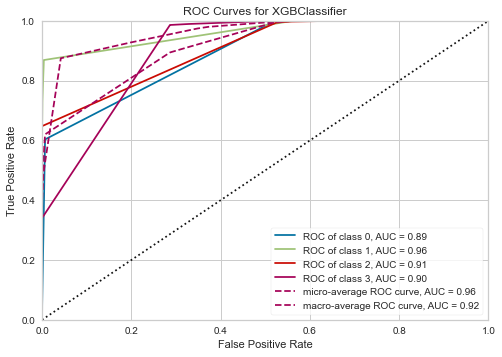

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [27]:
try:
    pc_class.plot_model(finalized_model, "auc")
except:
    print(f"Could not plot model.")

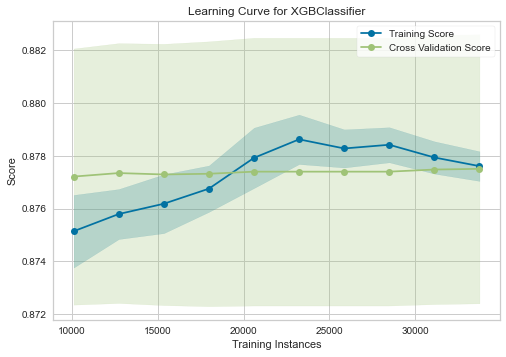

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [28]:
try:
    pc_class.plot_model(finalized_model, "learning")
except:
    print(f"Could not plot model.")

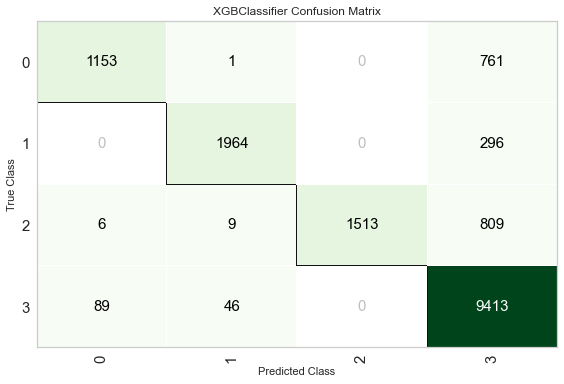

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [29]:
try:
    pc_class.plot_model(finalized_model, "confusion_matrix")
except:
    print(f"Could not plot model.")

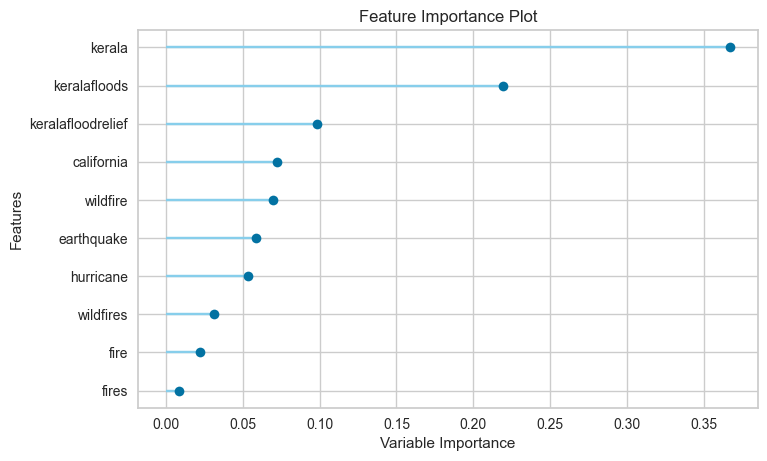

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [30]:
try:
    pc_class.plot_model(finalized_model, "feature")
except:
    print(f"Could not plot model.")

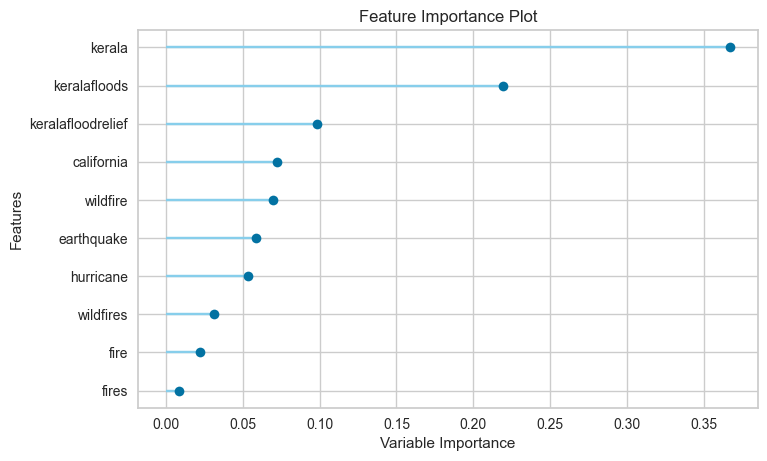

INFO - Visual Rendered Successfully
INFO - plot_model() succesfully completed......................................


In [36]:
try:
    pc_class.plot_model(finalized_model, "feature_all")
except:
    print(f"Could not plot model.")

In [31]:
predictions_train = pc_class.predict_model(finalized_model)
predictions_train

INFO - Initializing predict_model()
INFO - predict_model(display=None, ml_usecase=MLUsecase.CLASSIFICATION, verbose=True, round=4, raw_score=False, encoded_labels=False, probability_threshold=None, estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=39674, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0))
INFO - Checking exceptions
INFO - Preloading libraries
INFO - Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8744,0.9100,0.7761,0.8887,0.8679,0.7682,0.7844


,california,earthquake,fire,fires,hurricane,kerala,keralafloodrelief,keralafloods,wildfire,wildfires,event_type,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,flood,hurricane,0.7700
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,earthquake,earthquake,0.9207
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hurricane,hurricane,0.7700
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,hurricane,hurricane,0.9991
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fire,fire,0.8864
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,flood,flood,0.9997
16056,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,earthquake,earthquake,0.9207
16057,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,hurricane,hurricane,0.9991
16058,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,fire,fire,0.9991


In [32]:
test_vectorized_event_type_df

,california,earthquake,fire,fires,hurricane,kerala,keralafloodrelief,keralafloods,wildfire,wildfires,tweet_id,tweet_text,event_type
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798274825441538048,The earthquake in New Zealand was massive. Bil...,earthquake
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798452064208568320,These pictures show the alarming extent of the...,earthquake
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797804396767682560,Just woke to news of another earthquake! WTF N...,earthquake
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798434862830993408,"When theres an actual earthquake, landslide an...",earthquake
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797790705414377472,"Tsunami warning for entire East Coast of NZ, b...",earthquake
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15155,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783985895493865472,RT @rolandsmartin: 7AM ET on #NewsOneNow: Hurr...,hurricane
15156,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783746504129294336,RT @ILiveBeyond: Please pray for the people of...,hurricane
15157,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783864123167608832,Hurricane Matthew kills 26 in Caribbean on des...,hurricane
15158,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783528309963579392,An already struggling Haiti faced massive Hurr...,hurricane


In [33]:
predictions_test = pc_class.predict_model(finalized_model, data=test_vectorized_event_type_df)
predictions_test

INFO - Initializing predict_model()
INFO - predict_model(display=None, ml_usecase=MLUsecase.CLASSIFICATION, verbose=True, round=4, raw_score=False, encoded_labels=False, probability_threshold=None, estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=39674, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0))
INFO - Checking exceptions
INFO - Preloading libraries
INFO - Preparing display monitor


,california,earthquake,fire,fires,hurricane,kerala,keralafloodrelief,keralafloods,wildfire,wildfires,tweet_id,tweet_text,event_type,Label,Score
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798274825441538048,The earthquake in New Zealand was massive. Bil...,earthquake,earthquake,0.9207
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798452064208568320,These pictures show the alarming extent of the...,earthquake,hurricane,0.7700
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797804396767682560,Just woke to news of another earthquake! WTF N...,earthquake,earthquake,0.9207
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798434862830993408,"When theres an actual earthquake, landslide an...",earthquake,earthquake,0.9207
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797790705414377472,"Tsunami warning for entire East Coast of NZ, b...",earthquake,hurricane,0.7700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15155,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783985895493865472,RT @rolandsmartin: 7AM ET on #NewsOneNow: Hurr...,hurricane,hurricane,0.9991
15156,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783746504129294336,RT @ILiveBeyond: Please pray for the people of...,hurricane,hurricane,0.9991
15157,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783864123167608832,Hurricane Matthew kills 26 in Caribbean on des...,hurricane,hurricane,0.9991
15158,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,783528309963579392,An already struggling Haiti faced massive Hurr...,hurricane,hurricane,0.9991


In [34]:
end_time = datetime.now()
end_time.strftime("%Y/%m/%d %H:%M:%S")

'2021/10/02 17:51:59'

In [35]:
duration = end_time - start_time
print("duration :", duration)

duration : 0:07:37.551121
